# Get depth data for pose detections

## Setup

In [1]:
import sys
sys.path.append("../")

In [2]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import cv2
from common import plot_helpers
from skimage.segmentation import chan_vese
import pathlib
import json
import scipy
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits import mplot3d
from tqdm import tqdm
from common.realsense_params import MIN_VALID_DEPTH_METERS
from common.realsense_params import MAX_VALID_DEPTH_METERS

np.set_printoptions(suppress=True)
%matplotlib inline 
# %matplotlib notebook

In [3]:
%load_ext line_profiler

In [4]:
MIN_VALID_DEPTH_MM = MIN_VALID_DEPTH_METERS*1000
MAX_VALID_DEPTH_MM = MAX_VALID_DEPTH_METERS*1000


In [5]:
colormap = mcolors.LinearSegmentedColormap.from_list(
    "", plt.cm.viridis.colors, N=0xFFFF)

In [6]:
subj='QKZF-SWAL-UJPN'

# cam='lower'
# algorithm='openpose:25B'
# activity='simon-says'
# color_idx=1300

cam='upper'
algorithm='mp-hands'
activity='target-touch'
hand='left'
color_idx=22

data = h5py.File(f'/home/mjsobrep/Downloads/data/{subj}/{activity}/full_data-vid.hdf5', 'r')
pose_data=h5py.File(f'/home/mjsobrep/Downloads/data/{subj}/{activity}/full_data-novid.hdf5', 'r')
depth_idx=data[f'vid/{cam}/color/matched_depth_index'][color_idx]
color_img=data[f'vid/{cam}/color/data'][color_idx]
depth_img=data[f'vid/{cam}/depth/data'][depth_idx]

if algorithm=='mp-hands':
    poses=pose_data[f'vid/{cam}/pose/{algorithm}/{hand}/keypoints-median5/color'][color_idx][:,:2]
else:
    poses=pose_data[f'vid/{cam}/pose/{algorithm}/keypoints-median5/color'][color_idx]

In [65]:
data[f'vid/{cam}/depth/data'][0].shape

(720, 1280)

In [7]:
depth_img[depth_img < MIN_VALID_DEPTH_MM] = 0
depth_img[depth_img > MAX_VALID_DEPTH_MM] = 0

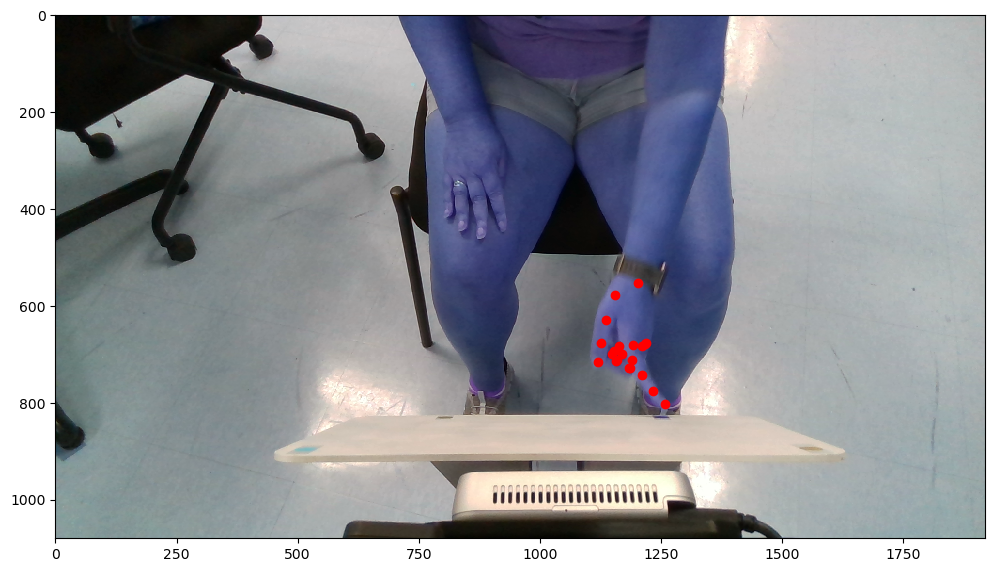

In [8]:
plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(color_img)
plt.plot(poses[:,0], poses[:,1],'or')

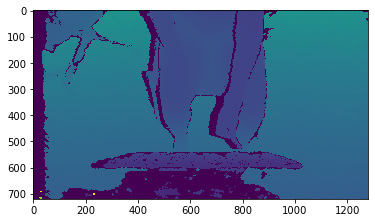

In [9]:
plt.imshow(depth_img)

## Intrinsics and Extrinsics

In [9]:
directory = pathlib.Path('/home/mjsobrep/Downloads/data/')
with open(directory/'transforms.json', encoding='utf-8') as json_file:
    transforms = json.load(json_file)

trans = (np.array([trans['translation']
                   for trans in transforms['robot'][cam].values()]))
rot = (np.array([trans['rotation']
                 for trans in transforms['robot'][cam].values()]))

# TODO: construct H matrix and use cv2 built in cv2.warpPerspective
r_cd = np.asarray(rot[0]).reshape(3, 3) 
t_cd = np.asarray(trans[0]).reshape(3, 1) * 1000 # convert from meters to millimeters 
k_c = data[f'vid/{cam}/color/data'].attrs['K'].reshape(3, 3)
inv_kc = np.linalg.inv(k_c)
k_d = data[f'vid/{cam}/depth/data'].attrs['K'].reshape(3, 3)

In [11]:
print(f'Kc:\n{k_c}')
print(f'Kd:\n{k_d}')
print(f'R:\n{r_cd}')
print(f'T:\n{t_cd}')

Kc:
[[1388.69726562    0.          980.37963867]
 [   0.         1387.66137695  547.88409424]
 [   0.            0.            1.        ]]
Kd:
[[897.11767578   0.         639.48754883]
 [  0.         897.11767578 360.43386841]
 [  0.           0.           1.        ]]
R:
[[ 0.99997014 -0.00298816 -0.00712956]
 [ 0.00296932  0.99999207 -0.00265167]
 [ 0.00713742  0.00263042  0.99997109]]
T:
[[14.8741696]
 [-0.2114892]
 [ 0.2002237]]


## Depth to color

Here we map the depth to the color images by passing through the indeces from the depth space to the color space.
The indeces are first made homogenous, then de-projected from the depth imager to world coordinates, using
the inverse of the depth K matrix. 

In [12]:
# %%timeit 99.8 ms ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

# Grid of index values | row 0: x, row 1: y 
indices=np.reshape(np.indices(np.flip(depth_img.shape)), (2,-1))
# Made homogenous by adding 1 to bottom | row 0: x, row 1: y, row 2: 1
indices_h = np.concatenate((indices, np.ones((1,indices.shape[1]))))

# Construct the homogenous tranformation between color and depth
HT = np.eye(4)
HT[:3, :3] = r_cd.T
HT[:3, 3] =  (t_cd).flatten() # TODO: is this complete
# # Make the inverse of that
HT_inv = HT.copy()
HT_inv[:3, :3] = np.linalg.inv(HT[:3, :3])
HT_inv[:3, 3] = -HT_inv[:3, :3]@HT[:3, 3]

# Transform to world using inverse of depth imager K matrix and remove scale ambiguity by multiply by z
# z is stored in milimeters, but everything else is meters
world_d = (np.linalg.inv(k_d)@indices_h)*(np.reshape(depth_img,(1,-1),order='F'))

# Make world coordinate homogenous
world_d_h = np.concatenate((world_d, np.ones((1, world_d.shape[1]))))
# Bring world coordinates from depth camera space to rgb camera space
world_c_h = HT@world_d_h
# Divide out depth to move back to pixel coordinates (should this come before/after the next step)
# world_c = world_c_h[:3,:]/world_c_h[2,:]
# Apply the camera projection matrix to finally end up back in rgb camera pixel coordinates
px_color = (k_c@world_c_h[:3,:])
valid_px_color = px_color[2,:] != 0
px_color_norm = px_color[:,valid_px_color]/px_color[2,valid_px_color]
depth_color = world_c_h[2,valid_px_color]
color_pixels = px_color_norm[:2,:].T

Check HT

In [13]:
print(f'HT:\n{HT}')

HT:
[[ 0.99997014  0.00296932  0.00713742 14.8741696 ]
 [-0.00298816  0.99999207  0.00263042 -0.2114892 ]
 [-0.00712956 -0.00265167  0.99997109  0.2002237 ]
 [ 0.          0.          0.          1.        ]]


These transformations are pretty small. I doubt the rotations are quite accurate. 

### Test transformation from depth pixels to depth world and back

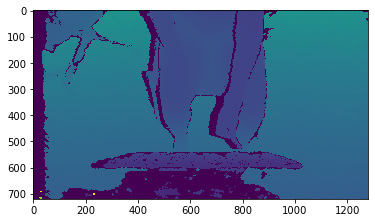

In [14]:
# project 3d points back into depth to make sure we did that right
im=np.zeros(depth_img.shape)
a=k_d@world_d
valid=a[2,:]!=0
a=a[:,valid]
dp=world_d[2,valid]
a=np.round(a/a[2,:]).astype('uint16')
im[a[1,:], a[0,:]]=world_d[2,valid]

plt.imshow(im)

### Test transformation to color camera pixel space

In [15]:
# %%timeit # 66.7 ms ± 733 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

def create_depth_projected(color_img_shape, color_pixels, world_c_h):
    im=np.zeros((color_img_shape[0], color_img_shape[1]))
    x_low=np.atleast_2d(np.floor(color_pixels[:,0])).astype('uint16')
    x_high=np.atleast_2d(np.ceil(color_pixels[:,0])).astype('uint16')
    y_low=np.atleast_2d(np.floor(color_pixels[:,1])).astype('uint16')
    y_high=np.atleast_2d(np.ceil(color_pixels[:,1])).astype('uint16')

    for points in (np.concatenate((x_low.T,y_low.T),axis=1),
                  np.concatenate((x_low.T,y_high.T),axis=1),
                  np.concatenate((x_high.T,y_low.T),axis=1),
                  np.concatenate((x_high.T,y_high.T),axis=1)):
        # points=np.ceil(c).astype('uint16')
        valid= np.all((points[:,0] > 0, points[:, 1]>0, points[:,0]<im.shape[1], points[:,1] <im.shape[0]), axis=0)
        im[points[valid,1], points[valid,0]] = world_c_h[2, valid]
    return(im)

# im = create_depth_projected(color_img.shape, color_pixels, world_c_h)

In [16]:
# %lprun -f create_depth_projected create_depth_projected(color_img.shape, color_pixels, world_c_h)

In [17]:
def create_depth_projected2(world_d, r_cd, t_cd, k_c, color_img_shape):
    color_pixels,_ = cv2.projectPoints(world_d.T,r_cd.T,t_cd,k_c,None)
    im=np.zeros((color_img_shape[0], color_img_shape[1]))
    color_pixels=np.round(color_pixels).astype('uint16')
    valid=np.all(color_pixels>=0, axis=2).flatten()
    valid=np.all((valid,(color_pixels[:,0,0]<color_img_shape[1])),axis=0)
    valid=np.all((valid, (color_pixels[:,0,1]<color_img_shape[0])),axis=0)
    im[color_pixels[valid,0,1], color_pixels[valid,0,0]]= world_d[2,valid]
    im=scipy.ndimage.maximum_filter(im,3)
    return(im)
# im=create_depth_projected2(world_d, r_cd, t_cd, k_c, color_img.shape)

In [18]:
# %lprun -f create_depth_projected2 create_depth_projected2(world_d, r_cd, t_cd, k_c, color_img.shape)

In [19]:
# %%timeit # 66.7 ms ± 733 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

def create_depth_projected3(color_img_shape, color_pixels, world_c_h):
    im=np.zeros((color_img_shape[0], color_img_shape[1]))
    points=np.round(color_pixels[:,:2]).astype('uint16')
    valid= np.all((points[:,0] > 0, points[:, 1]>0, points[:,0]<im.shape[1], points[:,1] <im.shape[0]), axis=0)
    im[points[valid,1], points[valid,0]] = world_c_h[2, valid]
    im=scipy.ndimage.maximum_filter(im,3) # take out in production
    return(im)


im = create_depth_projected3(color_img.shape, color_pixels, world_c_h)

In [20]:
# %lprun -f create_depth_projected3 create_depth_projected3(color_img.shape, color_pixels, world_c_h)

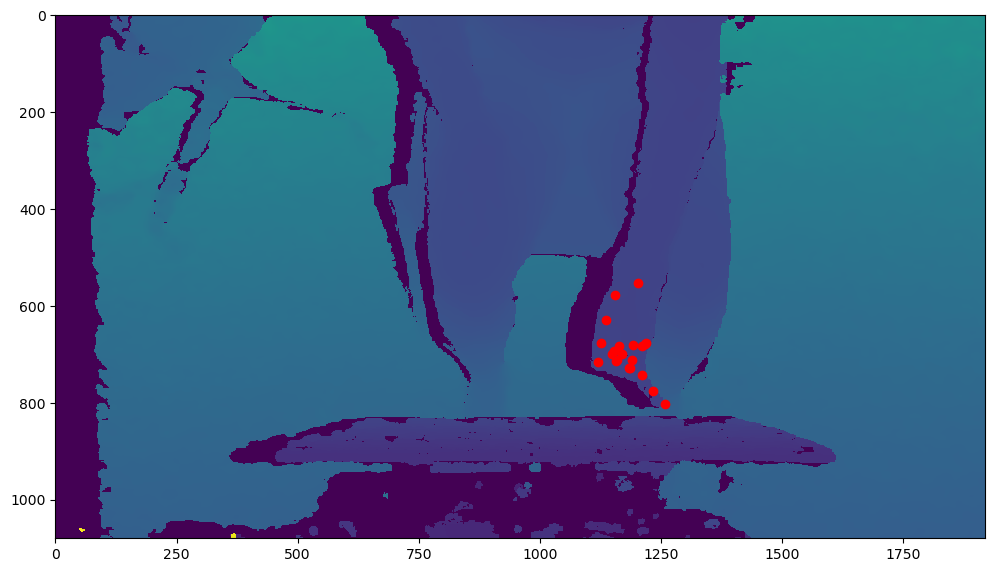

In [21]:
plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(im)
plt.plot(poses[:,0], poses[:,1],'or')

Get poses in 3D

In [22]:
int_poses=np.round(poses).astype('uint16')
depths=im[int_poses[:,1],int_poses[:,0]]
poses_3d_c = (inv_kc@np.concatenate((poses, np.ones((poses.shape[0],1))),axis=1).T)*depths
print(f'Keypoint positions in milimeters:\n{poses_3d_c.T}')

Keypoint positions in milimeters:
[[ 128.78824186    2.51903222  802.40022443]
 [ 101.06714475   17.5719443   803.5632939 ]
 [  89.53400448   46.55358054  795.57025384]
 [  83.74806636   74.46037142  799.53828949]
 [  82.71727732   98.08130666  816.48091565]
 [ 121.85516646   75.62117502  796.25501276]
 [ 133.10166542  111.60901832  799.08693531]
 [ 145.71896495  131.32682645  798.93954774]
 [ 243.35318641  223.72603126 1219.0073816 ]
 [ 133.45759633   77.56025     805.16270928]
 [ 120.41829425  106.60590212  822.19455114]
 [ 106.50543545   99.9662191   837.31420658]
 [ 102.07495505   91.35888245  839.36114007]
 [ 137.93927803   76.18888087  806.14053914]
 [ 121.55230024  106.23195703  819.18518364]
 [ 107.77470863   98.967509    837.30336403]
 [ 103.99244015   87.80359106  839.36439579]
 [ 138.09271801   75.09008035  805.14661695]
 [ 121.88823919   95.76087926  810.21624751]
 [ 113.72315066   90.90107155  837.28322103]
 [ 109.0304598    80.02505069  823.34254179]]


In [23]:
np.concatenate((poses, np.ones((poses.shape[0],1))),axis=1).T

array([[1203.27075195, 1155.04125977, 1136.66455078, 1125.83947754,
        1121.06787109, 1192.89941406, 1211.69104004, 1233.66479492,
        1257.60839844, 1210.55944824, 1183.7677002 , 1157.02038574,
        1149.25952148, 1218.00061035, 1186.43725586, 1159.12780762,
        1152.43127441, 1218.55859375, 1189.29406738, 1168.99804688,
        1164.2767334 ],
       [ 552.24047852,  578.2288208 ,  629.08447266,  677.11590576,
         714.57952881,  679.67175293,  741.69970703,  775.98291016,
         802.56341553,  681.55566406,  727.80853271,  713.55578613,
         698.92181396,  679.03289795,  727.83605957,  711.902771  ,
         693.04351807,  677.30102539,  711.89422607,  698.53790283,
         682.75830078],
       [   1.        ,    1.        ,    1.        ,    1.        ,
           1.        ,    1.        ,    1.        ,    1.        ,
           1.        ,    1.        ,    1.        ,    1.        ,
           1.        ,    1.        ,    1.        ,    1.        ,


Overlay depth and color to check alignment

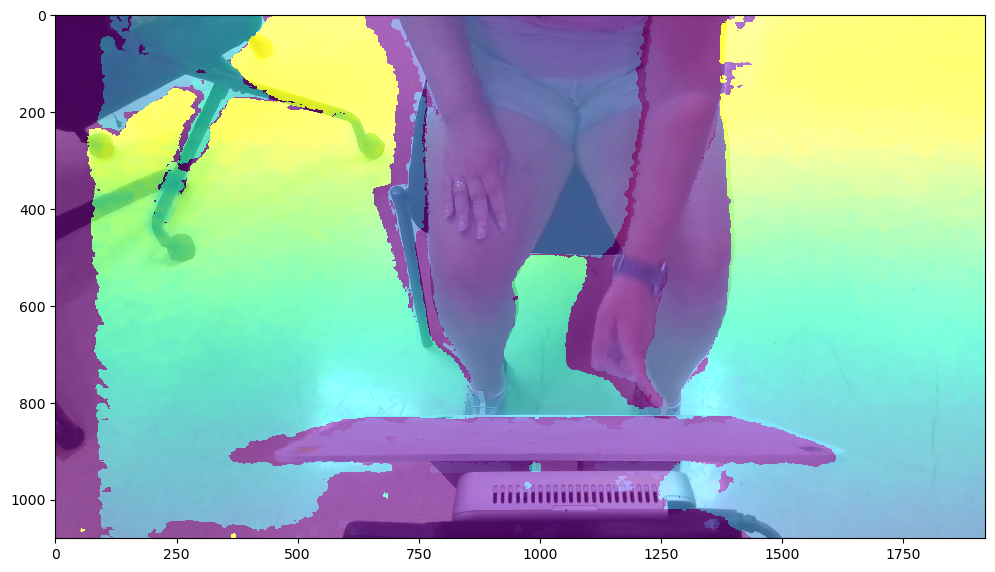

In [24]:
depth_img_s = plot_helpers.stretch_histogram(im.astype('uint16'))
depth_img_s = (colormap(depth_img_s) * 0xFFFF).astype(np.uint16)[:, :, :3]
# convert from 16 to 8 bit
depth_img_s = cv2.convertScaleAbs(depth_img_s, alpha=(0xFF/0xFFFF))
plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(cv2.addWeighted(cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB), .5, depth_img_s, 1,0))

### Bring Back to depth coordinates

In [25]:
color_pixels

array([[104143.58408053,   -917.85342339],
       [104143.58408053,   -917.85342339],
       [104143.58408053,   -917.85342339],
       ...,
       [104143.58408053,   -917.85342339],
       [104143.58408053,   -917.85342339],
       [104143.58408053,   -917.85342339]])

In [40]:
# %%timeit # 274 ms ± 6.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
def get_pose_depth(color_pixels, poses, depth_img, k_d):
    # KD Tree to find the nearest depth point to each keypoint in the color image
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='kd_tree', n_jobs=-1).fit(color_pixels)
    _, id = nbrs.kneighbors(poses)
    # Find the x and y positions in depth space for the corresponding keypoints
    row = id%depth_img.shape[0]
    col = (id-row)/depth_img.shape[0]
    poses_h=np.concatenate((col,row, np.ones((len(row),1))),axis=1).T
    poses_d = depth_img[np.round(row).astype('uint16'),np.round(col).astype('uint16')]
    poses_d = (np.linalg.inv(k_d)@poses_h)*(poses_d.T)
    return(poses_d, col, row)
poses_d, col, row=get_pose_depth(color_pixels, poses, depth_img, k_d)

In [37]:
# %lprun -f get_pose_depth get_pose_depth(color_pixels, poses, depth_img, k_d)

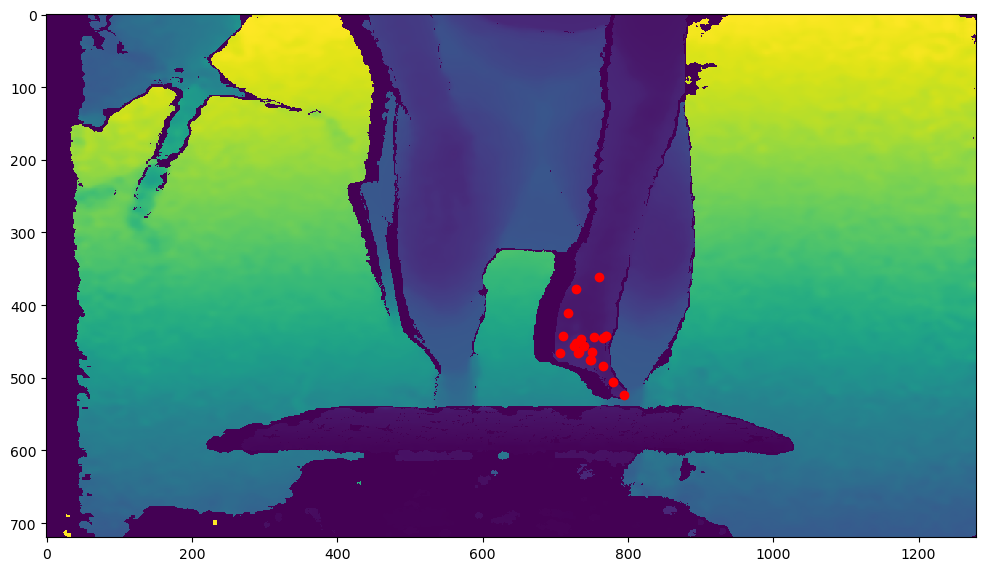

In [41]:
depth_img_s = plot_helpers.stretch_histogram(depth_img)
depth_img_s = (colormap(depth_img_s) * 0xFFFF).astype(np.uint16)[:, :, :3]
# convert from 16 to 8 bit
depth_img_s = cv2.convertScaleAbs(depth_img_s, alpha=(0xFF/0xFFFF))

plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(depth_img_s)
plt.plot(col, row,'or')

## Try to go quick
### Work in depth coordinates

In [202]:
k_c_padded = np.concatenate((k_c,np.zeros((3,1))),axis=1)
C_color = k_c_padded@HT
k_d_inv=np.linalg.inv(k_d)

In [210]:
# %%timeit # 220 ms ± 3.92 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

world_d = (k_d_inv@indices_h)*(np.reshape(depth_img,(1,-1),order='F'))

# Make world coordinate homogenous
world_d_h = np.concatenate((world_d, np.ones((1, world_d.shape[1]))))
# Bring world coordinates from depth camera space to rgb camera space
# Apply the camera projection matrix to finally end up back in rgb camera pixel coordinates
px_color = (C_color@world_d_h)
valid_px_color = px_color[2,:] != 0
px_color_norm = px_color[:,valid_px_color]/px_color[2,valid_px_color]
# depth_color = world_c_h[2,valid_px_color]
color_pixels1 = px_color_norm[:2,:].T

depth_locs=[np.where(np.all((color_pixels1[:,0]<pose[0]+1, 
                 color_pixels1[:,0]>pose[0]-1,
                 color_pixels1[:,1]<pose[1]+1, 
                 color_pixels1[:,1]>pose[1]-1),axis=0))[0] for pose in poses]
depth_locs_mind = np.array([depth_loc[np.argmin(depth_img.flatten(order='F')[depth_loc])] for depth_loc in depth_locs])
row = depth_locs_mind%depth_img.shape[0]
col = (depth_locs_mind-row)/depth_img.shape[0]
poses_in_depth=np.concatenate((np.atleast_2d(col),np.atleast_2d(row)),axis=0).T
poses_3d=world_d[:,depth_locs_mind].T

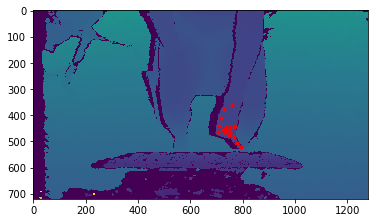

In [211]:
plt.imshow(depth_img)
plt.plot(poses_in_depth[:,0],poses_in_depth[:,1],'r.')

In [47]:
# %%timeit # 370 ms ± 6.01 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
color_pixels2,_ = cv2.projectPoints(world_d.T,r_cd.T,t_cd,k_c,None)
# np.max(color_pixels1 - np.squeeze(color_pixels2)) = 1.4551915228366852e-11

### Work in color coordinates

In [56]:
window = 1 # what area of depth to look over +/-. Will take closest depth in this pixel window (1=3x3, 2=5x5)
indices=np.reshape(np.indices(np.flip(depth_img.shape)), (2,-1))
# Made homogenous by adding 1 to bottom | row 0: x, row 1: y, row 2: 1
indices_h = np.concatenate((indices, np.ones((1,indices.shape[1]))))
HT = np.eye(4)
HT[:3, :3] = r_cd.T
HT[:3, 3] =  (t_cd).flatten()
k_c_padded = np.concatenate((k_c,np.zeros((3,1))),axis=1)
color_cam_matrix = k_c_padded@HT
k_d_inv=np.linalg.inv(k_d)
k_c_inv = np.linalg.inv(k_c)
HT_inv = HT.copy()
HT_inv[:3, :3] = np.linalg.inv(HT[:3, :3])
HT_inv[:3, 3] = -HT_inv[:3, :3]@HT[:3, 3]
def create_depth_projected3(color_img_shape, color_pixels, world_c_h):
    im=np.zeros((color_img_shape[0], color_img_shape[1]))
    points=np.round(color_pixels[:,:2]).astype('uint16')
    valid= np.all((points[:,0] > 0, points[:, 1]>0, points[:,0]<im.shape[1], points[:,1] <im.shape[0]), axis=0)
    im[points[valid,1], points[valid,0]] = world_c_h[2, valid]
    return(im)

In [60]:
# %%timeit # 111 ms ± 722 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

def extract_depth(depth_img, indices_h,k_d, k_d_inv, k_c_inv, HT_inv, color_cam_matrix,color_img_shape ):
    world_d = (k_d_inv@indices_h)*(np.reshape(depth_img,(1,-1),order='F'))
    # Make world coordinate homogenous
    world_d_h = np.concatenate((world_d, np.ones((1, world_d.shape[1]))))
    # Bring world coordinates from depth camera space to rgb camera space
    # Apply the camera projection matrix to finally end up back in rgb camera pixel coordinates
    px_color = (color_cam_matrix@world_d_h)
    valid_px_color = px_color[2,:] != 0
    px_color_norm = px_color[:,valid_px_color]/px_color[2,valid_px_color]
    # depth_color = world_c_h[2,valid_px_color]
    color_pixels4 = px_color_norm[:2,:].T

    im = create_depth_projected3(color_img_shape, color_pixels4, px_color)
    int_poses=np.round(poses).astype('uint16')
    depths=[np.max(im[pose[1]-window:pose[1]+window,pose[0]-window:pose[0]+window]) for pose in int_poses]
    poses_3d_c = (k_c_inv@np.concatenate((poses, np.ones((poses.shape[0],1))),axis=1).T)*depths
    poses_d_from_c=(HT_inv@np.concatenate((poses_3d_c, np.ones((1,poses_3d_c.shape[1]))),axis=0))[:3,:]
    poses_in_depth = k_d@poses_d_from_c
    poses_in_depth = (poses_in_depth/poses_in_depth[2,:])[:2,:].T
    return(poses_3d_c, poses_in_depth)

posed_3d_c, poses_in_depth=extract_depth(depth_img, indices_h,k_d, k_d_inv, k_c_inv, HT_inv, color_cam_matrix,color_img.shape )

In [63]:
%lprun -f extract_depth extract_depth(depth_img, indices_h,k_d, k_d_inv, k_c_inv, HT_inv, color_cam_matrix,color_img.shape )

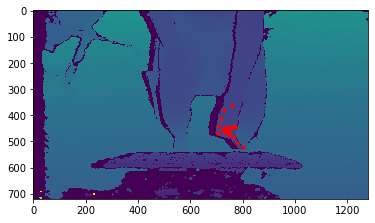

In [61]:
plt.imshow(depth_img)
plt.plot(poses_in_depth[:,0],poses_in_depth[:,1],'r.')

### Check Poses from all directions

In [62]:

print(f'Keypoint positions in milimeters:\n{poses_d.T}')

NameError: name 'poses_d' is not defined

In [212]:
# compare to from other side:
poses_d_from_c=(HT_inv@np.concatenate((poses_3d_c, np.ones((1,poses_3d_c.shape[1]))),axis=0))[:3,:]
print(f'Keypoint positions in milimeters in depth frame, calculated from color:\n{poses_d_from_c.T}')

Keypoint positions in milimeters in depth frame, calculated from color:
[[ 108.18317697    0.94158045  802.99700885]
 [  80.40963607   15.90897655  804.00178286]
 [  68.84722581   44.87733256  796.0028911 ]
 [  62.94978052   72.75620022  800.00292165]
 [  61.72764585   96.32896144  816.99983297]
 [ 101.07568091   74.03885278  796.99477991]
 [ 112.19411599  110.05229612  800.00155451]
 [ 124.75316921  129.80780364  799.99609227]
 [ 219.113471    221.38230393 1220.9916685 ]
 [ 112.6084617    75.98874344  805.99013055]
 [  99.36132707  104.95028495  823.0048144 ]
 [  85.36092821   98.22925058  838.00726495]
 [  80.94170662   89.60339883  839.99987607]
 [ 117.08713577   74.62809982  806.99631248]
 [ 100.51787202  104.58768987  820.00264428]
 [  86.63322505   97.23434601  838.00285504]
 [  82.86973493   86.05382059  840.00746571]
 [ 117.25094078   73.53239917  806.00062393]
 [ 100.94903467   94.14147517  811.00882228]
 [  92.60573661   89.18568867  838.00395108]
 [  88.04507616   78.3327859

In [208]:
print(f'Keypoint positions in milimeters in depth frame, calculated in direct path:\n{poses_3d}')

Keypoint positions in milimeters in depth frame, calculated in direct path:
[[ 107.73501453    0.506107    802.        ]
 [  80.22137194   15.7428286   804.        ]
 [  68.77571672   44.86662322  796.        ]
 [  62.87910991   72.73617167  800.        ]
 [  61.4079531    96.0208072   816.        ]
 [ 100.71801456   74.14706291  796.        ]
 [ 111.92507254  110.18945222  800.        ]
 [ 125.30124416  129.80783727  800.        ]
 [ 217.92477264  220.71301639 1218.        ]
 [ 112.4846979    75.78846302  804.        ]
 [  99.30550341  104.84554766  821.        ]
 [  85.48202332   97.67550082  838.        ]
 [  81.00437763   89.48162845  840.        ]
 [ 117.40215463   75.17170826  807.        ]
 [ 100.09858504  104.71784298  820.        ]
 [  86.41612597   96.74139817  838.        ]
 [  82.87704165   85.73630039  840.        ]
 [ 117.25667489   73.28169296  806.        ]
 [ 100.55935295   94.29532239  809.        ]
 [  92.02074188   89.26857695  838.        ]
 [  87.72791117   78.592